# Prolog

In [16]:
import pandas as pd
import seaborn as sb
import os
import OHCParser as op
import datetime
import traceback
from scipy.optimize import curve_fit
import pathlib

In [17]:
dfs = op.read_submissions()
dfs = op.derive_metrics(dfs)

# Sort columns ans save the DataFrame to a JSON file with pretty printing
# dfs = dfs.reindex(sorted(dfs.columns), axis=1)
# dfs.to_json("data.json", orient="records", lines=False, indent=4)

last time the data was updated 2025-09-05 13:41:14.838618  by  sles
03_OHC1_DrivAer_Result_Template_v3 Ruggero Poletto.xlsm: No energy data found


/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


10_Olenik_OHC1_FTP_S_MILAN250_CPU.xlsm: No energy data found
08_OHC1_DrivAer_Result_inductiva_65M Gabriel Marcos Magalhães.xlsm: No energy data found
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: number of timestep != number of wall clock time, assuming partial run
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: trying to fill wct, this makes only sense if N/A cases are contiguously to the right at the moment
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: No energy data found


In [18]:
df_hardware = dfs[dfs["Track"] == "Hardware Track"]
df_software = dfs[dfs["Track"] == "Software Track"]

fig_folder = "figures_overview"
doSaveFig = False  # Set to True to save figures

In [19]:
# olympic swimming pool 50m*25m*2m 2.5e6 l water
V = 2.5e6 #l water
cp = 4.184  # kJ / kg⋅K
dT = 80 #K,
rho = 1 #kg/l
# 1kJ = 0.0002778 kWh
e = V * rho * dT * cp * 0.0002778

In [20]:
dfs.columns

Index(['Contributor Affiliation', 'File Name', 'Run Wall-Clock Time [s]',
       'Pre-Processing Wall-Clock Time [s]', 'Storage File-System',
       'Number of CPU Cores', 'Number of GPU Devices', 'Number of Nodes',
       'CPU Family', 'CPU Model', 'CPU Submodel', 'CPU Generation',
       'GPU Model', 'Mesh', 'System TDP [W]', 'Number of Cells',
       'Time per Iteration [s]', 'Track', 'OpenFOAM Flavor',
       'Run Consumed Energy [kWh]', 'Decomposition Method', 'Last-Level Cache',
       'Network Interconnect', 'Renumbering Method', 'Contributor ID',
       'Is Partial', 'Is Energy Reported', 'Software Optimization Category',
       'Total Core Time [s]', 'Total Node Time [s]',
       'Energy per Iteration [J]', 'Energy per Iteration [kJ]',
       'Energy-To-Solution [kWh]', 'Time-To-Solution [h]',
       'Core-Time-To-Solution [h]', 'Node-Time-To-Solution [h]', 'FVOPS',
       'FVOPS per Energy', 'FVOPS per Energy per Iteration', 'FVOPS per Node'],
      dtype='object')

# Results

In [21]:
# some statistics
print(f"""
total number of valid entries: {len(dfs)},
hardware track entries {len(df_hardware)},
software track entries {len(df_software)} ,
processesed {len(set(dfs['CPU Family']))} CPU families with {len(set(dfs['CPU Submodel']))} CPU Submodels,
-------------------
break-down by CPU Family: {df_hardware["CPU Family"].value_counts()}
-------------------
max nodes {max(dfs['Number of Nodes'])},
mmax cores {max(dfs['Number of CPU Cores'])},
min wall clc {min(dfs['Run Wall-Clock Time [s]'])},
min time step {min(dfs['Time per Iteration [s]'])},
min energy {min(dfs['Energy-To-Solution [kWh]'])} [kWh],
max energy {max(dfs['Energy-To-Solution [kWh]'])} [kWh],
total reported energy consumption {sum(dfs['Energy-To-Solution [kWh]'])} kWh, bringing {sum(dfs['Energy-To-Solution [kWh]'])/e} olympic swimming pools worth of water to a boil
decomposition methods {set(dfs["Decomposition Method"])},
renumbering methods {set(dfs["Renumbering Method"])}
network {set(dfs["Network Interconnect"])},
""")


total number of valid entries: 237,
hardware track entries 175,
software track entries 62 ,
processesed 3 CPU families with 25 CPU Submodels,
-------------------
break-down by CPU Family: CPU Family
AMD      81
Intel    60
ARM      34
Name: count, dtype: int64
-------------------
max nodes 256,
mmax cores 32768,
min wall clc 0.0,
min time step 0.116968,
min energy 2.074825277777778 [kWh],
max energy 236.86655999999996 [kWh],
total reported energy consumption 4785.149739199097 kWh, bringing 0.020584561482113878 olympic swimming pools worth of water to a boil
decomposition methods {'custom', 'scotch', 'standard', 'hierarchical', 'Hierarchical', 'N/A', 'Scotch', 'hierarquical', 'Multilevel Scotch'},
renumbering methods {'standard', 'N/A', 'CuthillMcKee', 'RCM'}
network {'InfiniBand HDR       ', 'NVLink 3.0 + Mellanox HDR Infiniband', 'HDR100HCA 100 Gbps', 'Infiniband QDR 40GBs', 'RoCE', '/', 'InfiniBand (IB) HDR 200Gb/s', 'Slingshot-11 200 Gb/s', '-', 'N/A', 'NVIDIA ConnectX-6  100Gb/s',

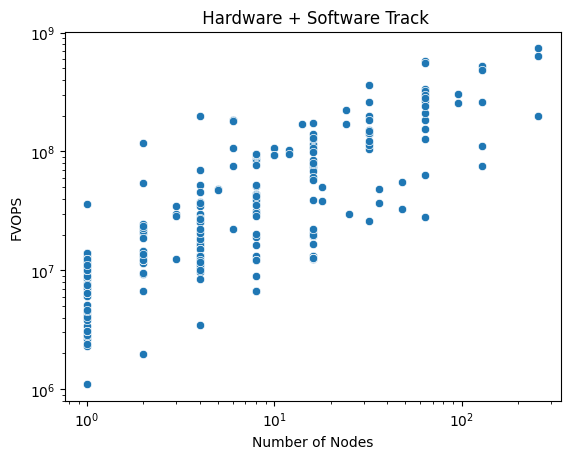

In [22]:
ax = sb.scatterplot(dfs, x="Number of Nodes", y="FVOPS")#, hue="Track")
ax.set(xscale="log", yscale="log", title=" Hardware + Software Track")
#sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPSAllsubs", doSaveFig)

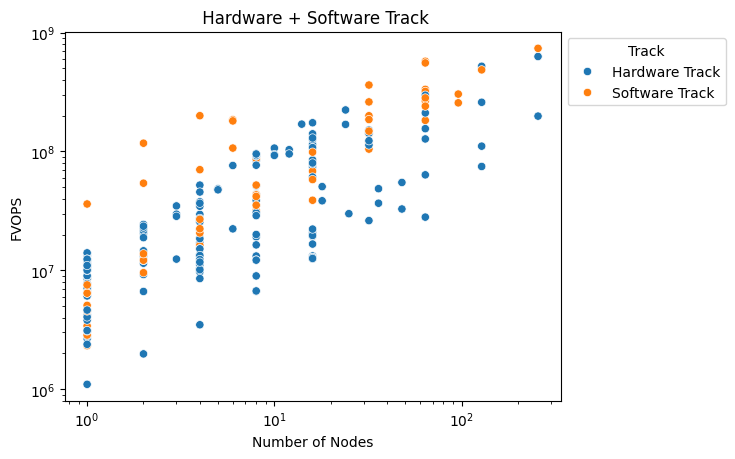

In [23]:
ax = sb.scatterplot(dfs, x="Number of Nodes", y="FVOPS", hue="Track")
ax.set(xscale="log", yscale="log", title=" Hardware + Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPSAllsubsByTrack", doSaveFig)

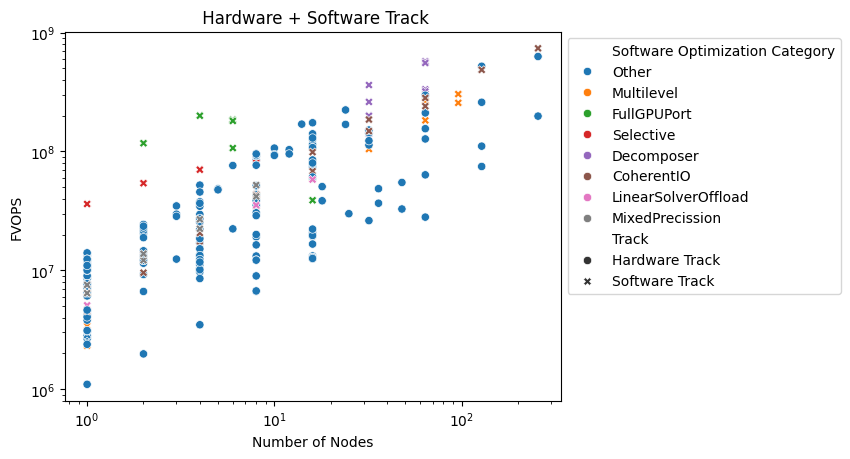

In [24]:
ax = sb.scatterplot(dfs, x="Number of Nodes", y="FVOPS", hue="Software Optimization Category", style="Track")
ax.set(xscale="log", yscale="log", title=" Hardware + Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPSAllsubsByType", doSaveFig)

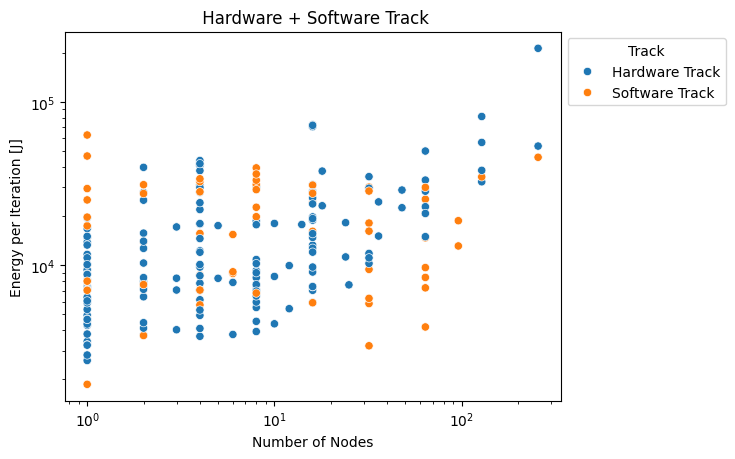

In [25]:
ax = sb.scatterplot(dfs, x="Number of Nodes", y="Energy per Iteration [J]", hue="Track")
ax.set(xscale="log", yscale="log", title=" Hardware + Software Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "FVOPSAllsubsEnergyPerIteration", doSaveFig)